In [1]:
'''
Rohan's version 
train.ipynb 
9/21/2020 

'''
import argparse
import collections
from pathlib import Path
import csv
import os 

import numpy as np 

import torch
import torch.optim as optim
from torchvision import transforms, utils as vision_utils 
#from torch.utils.tensorboard import SummaryWriter

from retinanet import model
from retinanet.dataloader import CocoDataset, CSVDataset, collater, Resizer, AspectRatioBasedSampler, Augmenter, \
    Normalizer, BalancedSampler
from torch.utils.data import DataLoader

from retinanet.sampler import SamplerFactory, aggregate_indices_per_class 


from retinanet import coco_eval
from retinanet import csv_eval

assert torch.__version__.split('.')[0] == '1'



/home/ubuntu/anaconda3/envs/tools/lib/python3.7/site-packages/imgaug/imgaug.py:184: DeprecationWarning: Function `SimplexNoiseAlpha()` is deprecated. Use `BlendAlphaSimplexNoise` instead. SimplexNoiseAlpha is deprecated. Use BlendAlphaSimplexNoise instead. The order of parameters is the same. Parameter 'first' was renamed to 'foreground'. Parameter 'second' was renamed to 'background'.
  warn_deprecated(msg, stacklevel=3)
/home/ubuntu/anaconda3/envs/tools/lib/python3.7/site-packages/imgaug/imgaug.py:184: DeprecationWarning: Function `FrequencyNoiseAlpha()` is deprecated. Use `BlendAlphaFrequencyNoise` instead. FrequencyNoiseAlpha is deprecated. Use BlendAlphaFrequencyNoise instead. The order of parameters is the same. Parameter 'first' was renamed to 'foreground'. Parameter 'second' was renamed to 'background'.
  warn_deprecated(msg, stacklevel=3)


In [2]:
MODELS_DIR = '/home/ubuntu/surgery-tool-detection/models/'
LOGS_DIR = '/home/ubuntu/surgery-tool-detection/logs/'

##MODELS_DIR = str(Path(__file__).resolve().parents[2]) + '/models/'
##LOGS_DIR = str(Path(__file__).resolve().parents[2]) + '/logs/'
# pretrained_model = MODELS_DIR + 'coco_resnet_50_map_0_335_state_dict.pt'

print('CUDA available: {}'.format(torch.cuda.is_available()))

print(MODELS_DIR) 

print(LOGS_DIR) 



CUDA available: True
/home/ubuntu/surgery-tool-detection/models/
/home/ubuntu/surgery-tool-detection/logs/


## Set up model configs

In [3]:
### Set up model configs ### 

parser = argparse.ArgumentParser(description='Simple training script for training a RetinaNet network.')

parser.add_argument('--dataset', help='Dataset type, must be one of csv or coco.')
parser.add_argument('--coco_path', help='Path to COCO directory')
parser.add_argument('--csv_train', help='Path to file containing training annotations (see readme)')
parser.add_argument('--csv_classes', help='Path to file containing class list (see readme)')
parser.add_argument('--csv_val', help='Path to file containing validation annotations (optional, see readme)')

parser.add_argument('--depth', help='Resnet depth, must be one of 18, 34, 50, 101, 152', type=int, default=50)
parser.add_argument('--epochs', help='Number of epochs', type=int, default=100)
parser.add_argument('--model_name', help='Name to store the trianed model under.')
parser.add_argument('--log_output', help='Save output to csv file', action='store_true')
parser.add_argument('--batch_size', type=int)
parser.add_argument('--learning_rate', type=float)
parser.add_argument('--threshold', help='iou threshold to count as detection')
parser.add_argument('--sampler', help='Type of sampler to use, default aspect ratio sampler.')
parser.add_argument('--augment', action='store_true')
parser.add_argument('--pretrained', help='Path to pretrained model')
parser.add_argument('--blacken', action='store_true')

#parser = parser.parse_args(args)


##### PRIMARY MODEL CONFIGS TO SET ### 

parser.model_name = '9.28_Model2' 

parser.augment = 0.9 #1.0 #0.7 #False 
parser.pipeline = 'my_pipeline_v2' #"kitchen_sink" #"my_pipeline_v3" #"rotate" #"my_pipeline_v1" #False 

#parser.sampler = None 
#parser.sampler = "old balanced (no alpha)" 
parser.sampler = 'new balanced' 
parser.alpha = 0.9   

parser.depth = 50 
parser.epochs = 60  
parser.num_workers = 3

##### END PRIMARY CONFIGS ######## 



parser.log_output = True 
LOG_DIR = LOGS_DIR + parser.model_name + '/'
os.makedirs(LOG_DIR, exist_ok=True) 

parser.dataset = 'csv' 
parser.csv_train = '/home/ubuntu/surgery-tool-detection/src/data/train_data.csv' #'../data/train_data.csv'
parser.csv_val = '/home/ubuntu/surgery-tool-detection/src/data/val_data.csv' #../val_data.csv 
parser.csv_classes = '/home/ubuntu/surgery-tool-detection/src/data/class_names_prune.csv' #../data/class_names.csv 


parser.blacken = False 
parser.learning_rate = None 

parser.batch_size = None ## Set and log config? 
parser.threshold = None ## Set and log config? 



configs = ['model_name', 'augment', 'pipeline', 'sampler', 'alpha', 'depth', 'epochs', 'num_workers'] #, log_output, dataset, csv_train] 

filename = '{}_configs.txt'.format(LOG_DIR + parser.model_name) 
config_log = open(filename, 'w') 

for config in configs: 
    value = getattr(parser, config) 
    output_line = '{}: {}\n'.format(config, value) 
    print(output_line) 
    config_log.write(output_line) 

config_log.close() 

model_name: 9.28_Model2

augment: 0.9

pipeline: my_pipeline_v2

sampler: new balanced

alpha: 0.9

depth: 50

epochs: 60

num_workers: 3



## Set up dataloaders, model, logging 

In [4]:
model_name = 'model'
if parser.model_name is not None:
    model_name = parser.model_name

learning_rate = 1e-5
if parser.learning_rate is not None:
    learning_rate = float(parser.learning_rate)

batch_size = 2
if parser.batch_size is not None:
    batch_size = int(parser.batch_size)

threshold = 0.5
if parser.threshold is not None:
    threshold = float(parser.threshold)

    
  

In [5]:
# Create the dataloaders     

if parser.dataset == 'coco':

    if parser.coco_path is None:
        raise ValueError('Must provide --coco_path when training on COCO,')

    dataset_train = CocoDataset(parser.coco_path, set_name='train2017',
                                transform=transforms.Compose([Normalizer(), Augmenter(), Resizer()]))
    dataset_val = CocoDataset(parser.coco_path, set_name='val2017',
                              transform=transforms.Compose([Normalizer(), Resizer()]))

elif parser.dataset == 'csv':

    if parser.csv_train is None:
        raise ValueError('Must provide --csv_train when training on COCO,')

    if parser.csv_classes is None:
        raise ValueError('Must provide --csv_classes when training on COCO,')

    dataset_train = CSVDataset(train_file=parser.csv_train, class_list=parser.csv_classes,
                               transform=transforms.Compose([Normalizer(), Augmenter(), Resizer()]), 
                               augment=parser.augment, pipeline=parser.pipeline, blacken=parser.blacken)
    train_acc_set = CSVDataset(train_file=parser.csv_train, class_list=parser.csv_classes,
                               transform=transforms.Compose([Normalizer(), Resizer()]), blacken=parser.blacken)

    if parser.csv_val is None:
        dataset_val = None
        print('No validation annotations provided.')
    else:
        dataset_val = CSVDataset(train_file=parser.csv_val, class_list=parser.csv_classes,
                                 transform=transforms.Compose([Normalizer(), Resizer()]))

else:
    raise ValueError('Dataset type not understood (must be csv or coco), exiting.')
    


sampler = AspectRatioBasedSampler(dataset_train, batch_size=batch_size, drop_last=False)
if parser.sampler is not None and parser.sampler == 'old balanced (no alpha)':
    sampler = BalancedSampler(dataset_train, batch_size=batch_size, drop_last=False) 
if parser.sampler is not None and parser.sampler == 'new balanced': 
    class_indices_dict = aggregate_indices_per_class(dataset_train) 
    class_indices = list(class_indices_dict.values()) 
    # print(len(class_indices)) 
    # for label in class_indices: print(len(label))
    #batch_sz = 2 
    # print("Hello") 
    # print(len(dataset_train)//batch_sz) 
    sampler = SamplerFactory().get(
        class_idxs=class_indices,
        batch_size=batch_size,
        n_batches=len(dataset_train)//batch_size,
        alpha=parser.alpha,
        kind='random'
    ) 
    
    
dataloader_train = DataLoader(dataset_train, num_workers=parser.num_workers, collate_fn=collater, batch_sampler=sampler) 


if dataset_val is not None:
    sampler_val = AspectRatioBasedSampler(dataset_val, batch_size=1, drop_last=False)
    dataloader_val = DataLoader(dataset_val, num_workers=parser.num_workers, collate_fn=collater, batch_sampler=sampler_val)



Using new Balanced Sampler


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1855
0
torch.Size([608, 1056, 3])


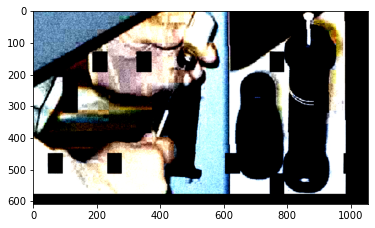

293
0
torch.Size([608, 1056, 3])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


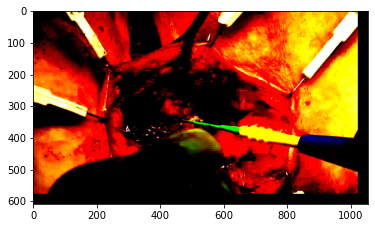

In [6]:
# Observe dataset 

# Make sure augmentations are being preserved in the dataset! 
# And this iterates in order so can see how augmentation changes as you run the pipeline over and over 


import matplotlib.pyplot as plt 
import cv2 
from retinanet.dataloader import CocoDataset, CSVDataset, collater, Resizer, AspectRatioBasedSampler, Augmenter, \
    UnNormalizer, Normalizer
unnormalize = UnNormalizer()

# print(len(dataset_train.image_data)) 
# print(len(dataset_val.image_data)) 

print(len(dataset_train)) 

for idx, sample in enumerate(dataset_train): 
    
    print(idx) 
    print(sample['img'].shape)  
    image = sample['img'] 
    plt.imshow(image) 
    plt.show() 
    
    if idx == 0: break 
        
        
print(len(dataset_val)) 

for idx, sample in enumerate(dataset_val): 
    
    print(idx) 
    print(sample['img'].shape)  
    image = sample['img'] 
    plt.imshow(image) 
    plt.show() 
    
    if idx == 0: break 

Using new Balanced Sampler
0
KUKObgS39yA-000003851.jpg
KUKObgS39yA
1
index:  1543
bovie


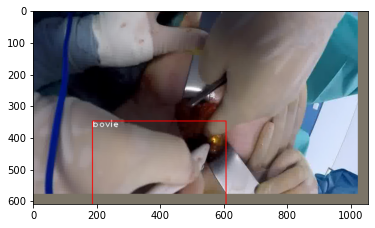

EWra7VzEiS4-000003211.jpg
EWra7VzEiS4
1
index:  1430


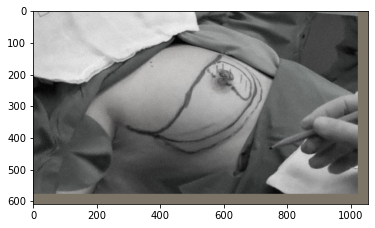

1
KUKObgS39yA-000011555.jpg
KUKObgS39yA
0
index:  1549
bovie


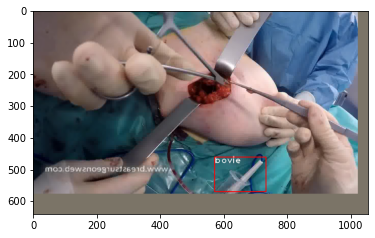

k0f8x5ZFnDs-000001423.jpg
k0f8x5ZFnDs
1
index:  638


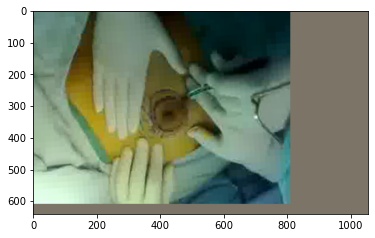

2
ATEuI_Y69CI-000002029.jpg
ATEuI_Y69CI
1
index:  1375


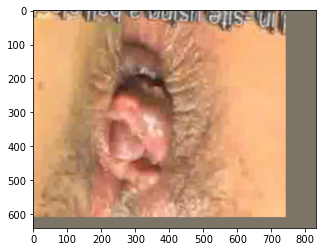

VvkCaxXqFfY-000002049.jpg
VvkCaxXqFfY
1
index:  872
bovie
needledriver
needledriver


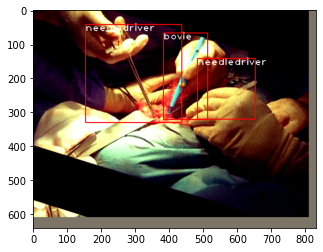

In [7]:
### Observe dataloader (Playing around cell)

# Check dataloader 
# Check dataloader augmentations: pipeline + frequency 
# Check dataloader batch logging properties like filename, vidID, tools present 
# Check dataloader sampling logic (over/undersampling) 

import matplotlib.pyplot as plt 
import cv2 
from retinanet.dataloader import CocoDataset, CSVDataset, collater, Resizer, AspectRatioBasedSampler, Augmenter, \
    UnNormalizer, Normalizer

unnormalize = UnNormalizer()

def draw_caption(image, box, caption): 
    b = np.array(box).astype(int)
    cv2.putText(image, caption, (b[0], b[1] + 20), cv2.FONT_HERSHEY_PLAIN, 2, (255, 255, 255), 2)
        

from collections import defaultdict 
from retinanet.train_utils import BatchLogger 


batchLogger = BatchLogger()      

batchLogger.index = {} 
class_indices_dict = aggregate_indices_per_class(dataset_train) 
# for class_, idxs in class_indices_dict.items(): 
#     idxdict = dict.fromkeys(idxs, [0, 0])  
#     batchLogger.index[class_] = idxdict 

for class_, idxs in class_indices_dict.items(): 
    idxdict = {idx : [0, 0] for idx in idxs} 
    batchLogger.index[class_] = idxdict
    
#print(batchLogger.index) 

# print(len(dataloader_train)) 
# print(len(dataloader_val)) 


for idx, data in enumerate(dataloader_train): 
    #if idx > 10: break 
    if idx > 2: break
    print(idx) 
#     print(data) 
#     print(len(data['img'])) 
#     print(len(data['annot'])) 
#     print(data['img'][0]) 
#     plt.imshow(data['img'][0]) 
#     plt.show() 
#     print(data) 
#     print(data['img'].shape) 
#     print(data['annot']) 
#     print(data['filename']) 


    for i in range(len(data['img'])): 
        img = np.array(255 * unnormalize(data['img'][i, :, :, :])).copy() # 1. Unnormalize 
        img[img < 0] = 0
        img[img > 255] = 255 
        img = np.transpose(img, (1, 2, 0))  # 2. Tranpose to correct channel in correct spot 
        img = cv2.cvtColor(img.astype(np.uint8), cv2.COLOR_BGR2RGB) # 3. Convert to correct color space 
        
        filename = data['filename'][i] 
        filename = filename.rsplit('/',1)[1] 
        videoID = '-'.join(filename.split('-')[:-1]) 
        print(filename) 
        print(videoID) 
        augmented = data['augmented'][i] 
        print(augmented) 
        
        index = data['index'][i] 
        print("index: ", index) 
        for class_, idxsdict in batchLogger.index.items(): 
            if index in idxsdict.keys(): 
                #print(batchLogger.index[class_]) 
                batchLogger.index[class_][index][augmented] += 1 
                #print(batchLogger.index[class_]) 
                break 
            
        
        batchLogger.filename[filename] += 1 
        batchLogger.videoID[videoID] += 1 
        
        tools_present = False 
        bovi = False 
        need = False 
        forc = False 
        scal = False 
        
        annots = np.array(data['annot'][i]) 
        for annot in annots:
            if annot[4] == -1: 
                continue 
            label_name = dataset_val.labels[annot[4]]
            
            print(label_name) 
            batchLogger.tool[label_name][augmented] += 1
            tools_present = True 
            if label_name == 'bovie': bovi = True 
            if label_name == 'needledriver': need = True 
            if label_name == 'forceps': forc = True 
            if label_name == 'scalpel': scal = True 
        
            
            x1 = int(annot[0])
            y1 = int(annot[1])
            x2 = int(annot[2])
            y2 = int(annot[3])
            draw_caption(img, (x1, y1, x2, y2), label_name)
            cv2.rectangle(img, (x1, y1), (x2, y2), color=(0, 0, 255), thickness=2)  
        
        plt.imshow(img[:, :, ::-1]) 
        plt.show() 
        #cv2.imwrite("inputvis/trainground_{}.png".format(idx), img) 
        
        if tools_present: 
            batchLogger.background['tools_present'] += 1 
        else: 
            batchLogger.background['tools_absent'] += 1
        if bovi : batchLogger.tool_frame['bovie'][augmented] += 1
        if need : batchLogger.tool_frame['needledriver'][augmented] += 1
        if forc : batchLogger.tool_frame['forceps'][augmented] += 1
        if scal : batchLogger.tool_frame['scalpel'][augmented] += 1
    

batchLogger.dictify() 


In [8]:
# Create the model

if parser.depth == 18:
    retinanet = model.resnet18(num_classes=dataset_train.num_classes(), pretrained=True)
elif parser.depth == 34:
    retinanet = model.resnet34(num_classes=dataset_train.num_classes(), pretrained=True)
elif parser.depth == 50:
    retinanet = model.resnet50(num_classes=dataset_train.num_classes(), pretrained=True)
elif parser.depth == 101:
    retinanet = model.resnet101(num_classes=dataset_train.num_classes(), pretrained=True)
elif parser.depth == 152:
    retinanet = model.resnet152(num_classes=dataset_train.num_classes(), pretrained=True)
else:
    raise ValueError('Unsupported model depth, must be one of 18, 34, 50, 101, 152')



In [9]:
# Create the loggers 

#tb = SummaryWriter('runs/{}'.format(model_name)) 

if parser.log_output:
    print('Logging training loss under {}_loss.csv'.format(LOG_DIR + model_name))
    loss_f = open('{}_loss.csv'.format(LOG_DIR + model_name), 'w')
    loss_logger = csv.writer(loss_f, delimiter=',')
    loss_logger.writerow(['Epoch', 'Iteration', 'Classification Loss', 'Regression Loss', 'Running Loss'])

    print('Logging training accuracy under {}_train.csv'.format(LOG_DIR + model_name))
    train_f = open('{}_train.csv'.format(LOG_DIR + model_name), 'w')
    train_logger = csv.writer(train_f, delimiter=',')
    train_logger.writerow(['Epoch'] + [dataset_train.label_to_name(label) for label in (0, 2, 3)] #range(dataset_train.num_classes())]
                         + ['Overall']) 
    
    
    print('Logging batch construction per epoch under {}_batches.csv'.format(LOG_DIR + model_name)) 
    batch_f = open('{}_batches.csv'.format(LOG_DIR + model_name), 'w') 
    batch_logger = csv.writer(batch_f, delimiter=',') 
    batch_logger.writerow(['Epoch'] 
                      + ['Total {}'.format(dataset_train.label_to_name(label)) for label in (0, 2, 3)] #range(dataset_train.num_classes())]
                      + ['Normal {}'.format(dataset_train.label_to_name(label)) for label in (0, 2, 3)] #range(dataset_train.num_classes())]
                      + ['Augmented {}'.format(dataset_train.label_to_name(label)) for label in (0, 2, 3)] #range(dataset_train.num_classes())]
                     ) 

    
    if parser.csv_val is not None:
        print('Logging validation output under {}_validation.csv'.format(LOG_DIR + model_name))
        validation_f = open('{}_validation.csv'.format(LOG_DIR + model_name), 'w')
        val_logger = csv.writer(validation_f, delimiter=',')
        val_logger.writerow(
            ['Epoch'] + [dataset_val.label_to_name(label) for label in (0, 2, 3)] #range(dataset_val.num_classes())] 
                         + ['Overall'])


Logging training loss under /home/ubuntu/surgery-tool-detection/logs/9.28_Model2/9.28_Model2_loss.csv
Logging training accuracy under /home/ubuntu/surgery-tool-detection/logs/9.28_Model2/9.28_Model2_train.csv
Logging batch construction per epoch under /home/ubuntu/surgery-tool-detection/logs/9.28_Model2/9.28_Model2_batches.csv
Logging validation output under /home/ubuntu/surgery-tool-detection/logs/9.28_Model2/9.28_Model2_validation.csv


## More model setup 

In [10]:
use_gpu = True

if use_gpu:
    if torch.cuda.is_available():
        retinanet = retinanet.cuda()

if torch.cuda.is_available():
    retinanet = torch.nn.DataParallel(retinanet).cuda()
else:
    retinanet = torch.nn.DataParallel(retinanet)

print(retinanet) 
# Ensure that the model is wrapped in only a single nn.DataParallel wrapper! 
# Once this cell has been run once, don't run again!  Restart kernel if you do. 



DataParallel(
  (module): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
      

In [11]:
retinanet.training = True

optimizer = optim.Adam(retinanet.parameters(), lr=learning_rate)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, verbose=True)

loss_hist = collections.deque(maxlen=500)

retinanet.train()

print('Num training images: {}'.format(len(dataset_train)))

print('Num val images: {}'.format(len(dataset_val)))


Num training images: 1855
Num val images: 293


## Training loop

In [ ]:
import time

import matplotlib.pyplot as plt 
from collections import defaultdict 
from retinanet.train_utils import BatchLogger 


batchLogger = BatchLogger()                   
master_batch_logger = {} 

batchLogger.index = {} 
class_indices_dict = aggregate_indices_per_class(dataset_train) 
for class_, idxs in class_indices_dict.items(): 
    idxdict = {idx : [0, 0] for idx in idxs} 
    batchLogger.index[class_] = idxdict


t0 = time.time() 


for epoch_num in range(parser.epochs):

    retinanet.train()
    retinanet.module.freeze_bn()
    
    # Timing 
    t1 = time.time()
    tot_secs = t1-t0 
    secs = tot_secs % (24 * 3600) 
    hrs = secs // 3600
    secs %= 3600
    mins = secs // 60
    secs %= 60
    print("%d:%02d:%02d" % (hrs, mins, secs)) 
    print("to train {} epochs".format(epoch_num))         

    epoch_loss = []

    for iter_num, data in enumerate(dataloader_train):         

        try:
            
            # Batch logging! 
            
            for i in range(len(data['img'])):     
                filename = data['filename'][i].rsplit('/',1)[1] 
                videoID = '-'.join(filename.split('-')[:-1]) 
                index = data['index'][i] 
                augmented = data['augmented'][i]  

                batchLogger.filename[filename] += 1 
                batchLogger.videoID[videoID] += 1 
                for class_, idxsdict in batchLogger.index.items(): 
                    if index in idxsdict.keys(): 
                        batchLogger.index[class_][index][augmented] += 1 
                        break 

                tools_present = False 
                bovi = False 
                need = False 
                forc = False 
                scal = False 

                annots = np.array(data['annot'][i]) 
                for annot in annots:
                    if annot[4] == -1: 
                        continue 
                    label_name = dataset_val.labels[annot[4]]
                    batchLogger.tool[label_name][augmented] += 1
                    tools_present = True 
                    if label_name == 'bovie': bovi = True 
                    if label_name == 'needledriver': need = True 
                    if label_name == 'forceps': forc = True 
                    if label_name == 'scalpel': scal = True 

                if tools_present: 
                    batchLogger.background['tools_present'] += 1 
                else: 
                    batchLogger.background['tools_absent'] += 1
                if bovi : batchLogger.tool_frame['bovie'][augmented] += 1
                if need : batchLogger.tool_frame['needledriver'][augmented] += 1
                if forc : batchLogger.tool_frame['forceps'][augmented] += 1
                if scal : batchLogger.tool_frame['scalpel'][augmented] += 1
                if not tools_present : 
                    batchLogger.tool_frame['background'][augmented] += 1
                    batchLogger.tool['background'][augmented] += 1
            
            
            # Training 
            
            optimizer.zero_grad()

            if torch.cuda.is_available():
                classification_loss, regression_loss = retinanet([data['img'].cuda().float(), data['annot']])
            else:
                classification_loss, regression_loss = retinanet([data['img'].float(), data['annot']])

            classification_loss = classification_loss.mean()
            regression_loss = regression_loss.mean()

            loss = classification_loss + regression_loss

            if bool(loss == 0):
                continue

            loss.backward()

            torch.nn.utils.clip_grad_norm_(retinanet.parameters(), 0.1)

            optimizer.step()

            loss_hist.append(float(loss))

            epoch_loss.append(float(loss))
            
            if iter_num % 20 == 0: 
                print('Epoch: {} | Iteration: {} | Classification loss: {:1.5f} | Regression loss: {:1.5f} | Running loss: {:1.5f}'.format(
                        epoch_num, iter_num, float(classification_loss), float(regression_loss), np.mean(loss_hist)))

            if parser.log_output:
                loss_logger.writerow(['{}'.format(epoch_num), '{}'.format(iter_num), '{:1.5f}'.format(float(classification_loss)),
                                       '{:1.5f}'.format(float(regression_loss)), '{:1.5f}'.format(np.mean(loss_hist))])
                loss_f.flush()
                validation_f.flush()
                train_f.flush()
                batch_f.flush() 

            del classification_loss
            del regression_loss
        except Exception as e:
            print("Exception triggered") 
            print(e)
            continue

    if parser.dataset == 'coco':

        print('Evaluating dataset')

        coco_eval.evaluate_coco(dataset_val, retinanet)

    elif parser.dataset == 'csv' and parser.csv_val is not None:
        
        if epoch_num % 10 == 1:
            print('Evaluating dataset on training')
            train_mAP, train_pr = csv_eval.evaluate(train_acc_set, retinanet, iou_threshold=threshold)
            #tb.add_scalars('Training mAP', {train_acc_set.label_to_name(label): train_mAP[label][0] for label in
            #                                range(train_acc_set.num_classes())}, epoch_num)
            overall_train_mAP = np.mean(np.array([train_mAP[label][0] for label in (0, 2, 3)])) #range(dataset_train.num_classes())])) 
            print("Overall: {}".format(overall_train_mAP)) 

        print('Evaluating dataset on validation')
        mAP, pr_curve = csv_eval.evaluate(dataset_val, retinanet, iou_threshold=threshold)
        #tb.add_scalars('Validation mAP', {dataset_val.label_to_name(label): mAP[label][0] for label in
        #                                range(dataset_val.num_classes())}, epoch_num)
        overall_mAP = np.mean(np.array([mAP[label][0] for label in (0, 2, 3)])) #range(dataset_val.num_classes())])) 
        print("Overall: {}".format(overall_mAP)) 

        if parser.log_output:
            val_logger.writerow([str(epoch_num)] + [mAP[label][0] for label in (0, 2, 3)]) #range(dataset_val.num_classes())] + [overall_mAP])
            if epoch_num % 10 == 1:
                train_logger.writerow([str(epoch_num)] + [train_mAP[label][0] for label in (0, 2, 3)]) #range(dataset_train.num_classes())] + [overall_train_mAP])

                
        # Batch logging!  (Per epoch)  
        tooldict, toolframedict = batchLogger.tool, batchLogger.tool_frame #batchLogger 
        master_batch_logger[epoch_num] = tooldict, toolframedict 
        batch_logger.writerow([str(epoch_num)] 
                          + [np.sum(batchLogger.tool[dataset_train.label_to_name(label)]) for label in (0, 2, 3)] #range(dataset_train.num_classes())]
                          + [batchLogger.tool[dataset_train.label_to_name(label)][0] for label in (0, 2, 3)] #range(dataset_train.num_classes())]
                          + [batchLogger.tool[dataset_train.label_to_name(label)][1] for label in (0, 2, 3)] #range(dataset_train.num_classes())]
                         )
        print(batchLogger.tool) #
        
        # Save final batch logger state to .txt file.  Overwrite on every epoch. 
        attributes = ['filename', 'videoID', 'index', 'tool', 'tool_frame', 'background'] 
        filename = '{}_finalBatchLogger.txt'.format(LOG_DIR + parser.model_name) 
        final_batch_log = open(filename, 'w') 
        batchLogger.dictify() 
    
        final_batch_log.write("Epoch: " + str(epoch_num) + '\n') 
        for a in attributes: 
            out_dict = getattr(batchLogger, a) 
            if a == 'index': 
                for k, v in out_dict.items(): 
                    final_batch_log.write(str(k)) 
                    final_batch_log.write('\n') 
                    final_batch_log.write(str(v))
                    final_batch_log.write('\n') 
            else: 
                final_batch_log.write(str(out_dict)) 
                final_batch_log.write('\n') 
        final_batch_log.close() 
        
        batchLogger.undictify() 
        
                
    scheduler.step(np.mean(epoch_loss))

    torch.save(retinanet.module, '{}_incomplete.pt'.format(LOG_DIR + model_name))
    
    
loss_f.close()
train_f.close()
validation_f.close()
# batch_f.close() 
retinanet.eval()

torch.save(retinanet, '{}_final.pt'.format(LOG_DIR + model_name)) 


Using new Balanced Sampler
0:00:00
to train 0 epochs


/home/ubuntu/surgery-tool-detection/src/pytorch-retinanet/retinanet/model.py:52: UserWarning: Mixed memory format inputs detected while calling the operator. The operator will output contiguous tensor even if some of the inputs are in channels_last format. (Triggered internally at  /opt/conda/conda-bld/pytorch_1595629403081/work/aten/src/ATen/native/TensorIterator.cpp:918.)
  P4_x = P5_upsampled_x + P4_x
/home/ubuntu/surgery-tool-detection/src/pytorch-retinanet/retinanet/model.py:57: UserWarning: Mixed memory format inputs detected while calling the operator. The operator will output channels_last tensor even if some of the inputs are not in channels_last format. (Triggered internally at  /opt/conda/conda-bld/pytorch_1595629403081/work/aten/src/ATen/native/TensorIterator.cpp:924.)
  P3_x = P3_x + P4_upsampled_x


Epoch: 0 | Iteration: 0 | Classification loss: 0.56953 | Regression loss: 0.52335 | Running loss: 1.09287
Epoch: 0 | Iteration: 20 | Classification loss: 0.51841 | Regression loss: 0.50880 | Running loss: 1.70326
Epoch: 0 | Iteration: 40 | Classification loss: 0.44246 | Regression loss: 0.49060 | Running loss: 1.54977
Epoch: 0 | Iteration: 60 | Classification loss: 0.42700 | Regression loss: 0.49192 | Running loss: 1.44490
Epoch: 0 | Iteration: 80 | Classification loss: 0.70142 | Regression loss: 1.07343 | Running loss: 1.46494
Epoch: 0 | Iteration: 100 | Classification loss: 0.73766 | Regression loss: 1.05314 | Running loss: 1.43839
Epoch: 0 | Iteration: 120 | Classification loss: 0.37686 | Regression loss: 0.78968 | Running loss: 1.37324
Epoch: 0 | Iteration: 140 | Classification loss: 0.69192 | Regression loss: 1.11923 | Running loss: 1.35210
Epoch: 0 | Iteration: 160 | Classification loss: 0.45142 | Regression loss: 0.56979 | Running loss: 1.32790
Epoch: 0 | Iteration: 180 | Classi

Epoch: 1 | Iteration: 580 | Classification loss: 0.60205 | Regression loss: 0.90922 | Running loss: 1.04423
Epoch: 1 | Iteration: 600 | Classification loss: 0.24435 | Regression loss: 0.42532 | Running loss: 1.03634
Epoch: 1 | Iteration: 620 | Classification loss: 0.35141 | Regression loss: 0.65973 | Running loss: 1.03196
Epoch: 1 | Iteration: 640 | Classification loss: 0.26381 | Regression loss: 0.44727 | Running loss: 1.02756
Epoch: 1 | Iteration: 660 | Classification loss: 0.34296 | Regression loss: 0.45771 | Running loss: 1.02407
Epoch: 1 | Iteration: 700 | Classification loss: 0.56748 | Regression loss: 0.90879 | Running loss: 1.01102
Epoch: 1 | Iteration: 720 | Classification loss: 0.18022 | Regression loss: 0.25682 | Running loss: 1.01140
Epoch: 1 | Iteration: 740 | Classification loss: 0.60234 | Regression loss: 0.81761 | Running loss: 1.01689
Epoch: 1 | Iteration: 760 | Classification loss: 0.12683 | Regression loss: 0.38533 | Running loss: 1.01328
Epoch: 1 | Iteration: 780 | 

0:20:42
to train 3 epochs
Epoch: 3 | Iteration: 20 | Classification loss: 0.48141 | Regression loss: 0.73367 | Running loss: 0.97950
Epoch: 3 | Iteration: 60 | Classification loss: 0.39070 | Regression loss: 0.61551 | Running loss: 0.96731
Epoch: 3 | Iteration: 80 | Classification loss: 0.42179 | Regression loss: 0.70243 | Running loss: 0.96587
Epoch: 3 | Iteration: 100 | Classification loss: 0.49938 | Regression loss: 0.84735 | Running loss: 0.96854
Epoch: 3 | Iteration: 120 | Classification loss: 0.48548 | Regression loss: 0.72081 | Running loss: 0.96888
Epoch: 3 | Iteration: 140 | Classification loss: 0.22581 | Regression loss: 0.51544 | Running loss: 0.96473
Epoch: 3 | Iteration: 160 | Classification loss: 0.36702 | Regression loss: 0.69739 | Running loss: 0.96141
Epoch: 3 | Iteration: 180 | Classification loss: 0.53410 | Regression loss: 0.74059 | Running loss: 0.95649
Epoch: 3 | Iteration: 200 | Classification loss: 0.20592 | Regression loss: 0.18955 | Running loss: 0.95085
Epoch

Epoch: 4 | Iteration: 640 | Classification loss: 0.35899 | Regression loss: 0.57571 | Running loss: 0.89801
Epoch: 4 | Iteration: 660 | Classification loss: 0.35341 | Regression loss: 0.69147 | Running loss: 0.89160
Epoch: 4 | Iteration: 680 | Classification loss: 0.33360 | Regression loss: 0.61786 | Running loss: 0.90138
Epoch: 4 | Iteration: 700 | Classification loss: 0.37278 | Regression loss: 0.59424 | Running loss: 0.89770
Epoch: 4 | Iteration: 720 | Classification loss: 0.23516 | Regression loss: 0.36613 | Running loss: 0.89612
Epoch: 4 | Iteration: 740 | Classification loss: 0.35136 | Regression loss: 0.85185 | Running loss: 0.90640
Epoch: 4 | Iteration: 760 | Classification loss: 0.44360 | Regression loss: 0.72139 | Running loss: 0.88599
Epoch: 4 | Iteration: 780 | Classification loss: 0.46445 | Regression loss: 0.74348 | Running loss: 0.88762
Epoch: 4 | Iteration: 800 | Classification loss: 0.40449 | Regression loss: 0.82189 | Running loss: 0.88459
Epoch: 4 | Iteration: 820 | 

Epoch: 6 | Iteration: 280 | Classification loss: 0.09824 | Regression loss: 0.27083 | Running loss: 0.88043
Epoch: 6 | Iteration: 300 | Classification loss: 1.28827 | Regression loss: 0.41000 | Running loss: 0.88027
Epoch: 6 | Iteration: 320 | Classification loss: 0.08886 | Regression loss: 0.19186 | Running loss: 0.87283
Epoch: 6 | Iteration: 340 | Classification loss: 0.28857 | Regression loss: 0.60098 | Running loss: 0.87102
Epoch: 6 | Iteration: 360 | Classification loss: 0.56782 | Regression loss: 0.75608 | Running loss: 0.87796
Epoch: 6 | Iteration: 380 | Classification loss: 0.42927 | Regression loss: 0.58368 | Running loss: 0.88000
Epoch: 6 | Iteration: 400 | Classification loss: 0.34437 | Regression loss: 0.47453 | Running loss: 0.87546
Epoch: 6 | Iteration: 420 | Classification loss: 0.13119 | Regression loss: 0.19300 | Running loss: 0.86859
Epoch: 6 | Iteration: 440 | Classification loss: 1.15561 | Regression loss: 0.35311 | Running loss: 0.86344
Epoch: 6 | Iteration: 460 | 

Epoch: 7 | Iteration: 840 | Classification loss: 0.34273 | Regression loss: 0.54482 | Running loss: 0.84477
Epoch: 7 | Iteration: 860 | Classification loss: 0.51703 | Regression loss: 0.73246 | Running loss: 0.84615
Epoch: 7 | Iteration: 880 | Classification loss: 0.32549 | Regression loss: 0.73406 | Running loss: 0.84695
Epoch: 7 | Iteration: 900 | Classification loss: 0.08822 | Regression loss: 0.19694 | Running loss: 0.83929
Epoch: 7 | Iteration: 920 | Classification loss: 0.29765 | Regression loss: 0.53676 | Running loss: 0.83658
Evaluating dataset on validation
bovie Recall: 0.8689989462592205
bovie Precision: 0.12241134523950033
forceps Recall: 0.2951200738916256
forceps Precision: 0.06204781002095321
needledriver Recall: 0.8114659130439782
needledriver Precision: 0.05104312642346942

mAP:
bovie: 0.572496457066286
forceps: 0.1513186787284266
needledriver: 0.30985334225828215
Overall: 0.34455615935099826
{'bovie': [465, 4139], 'scalpel': [0, 0], 'forceps': [423, 3999], 'needledriv

Epoch: 9 | Iteration: 540 | Classification loss: 0.16688 | Regression loss: 0.28295 | Running loss: 0.79176
Epoch: 9 | Iteration: 560 | Classification loss: 0.34824 | Regression loss: 0.72838 | Running loss: 0.79487
Epoch: 9 | Iteration: 580 | Classification loss: 0.62193 | Regression loss: 0.44300 | Running loss: 0.79818
Epoch: 9 | Iteration: 600 | Classification loss: 0.43188 | Regression loss: 0.49688 | Running loss: 0.79495
Epoch: 9 | Iteration: 620 | Classification loss: 0.11393 | Regression loss: 0.28254 | Running loss: 0.79142
Epoch: 9 | Iteration: 640 | Classification loss: 0.50177 | Regression loss: 0.81372 | Running loss: 0.79045
Epoch: 9 | Iteration: 660 | Classification loss: 0.27252 | Regression loss: 0.54872 | Running loss: 0.78987
Epoch: 9 | Iteration: 680 | Classification loss: 0.35252 | Regression loss: 0.64659 | Running loss: 0.78685
Epoch: 9 | Iteration: 720 | Classification loss: 0.39807 | Regression loss: 0.61368 | Running loss: 0.78749
Epoch: 9 | Iteration: 740 | 

Epoch: 11 | Iteration: 140 | Classification loss: 0.16495 | Regression loss: 0.36463 | Running loss: 0.76163
Epoch: 11 | Iteration: 200 | Classification loss: 0.35294 | Regression loss: 0.69119 | Running loss: 0.76549
Epoch: 11 | Iteration: 220 | Classification loss: 0.42956 | Regression loss: 0.62839 | Running loss: 0.76812
Epoch: 11 | Iteration: 240 | Classification loss: 0.27832 | Regression loss: 0.80339 | Running loss: 0.77140
Epoch: 11 | Iteration: 260 | Classification loss: 0.19239 | Regression loss: 0.38325 | Running loss: 0.76760
Epoch: 11 | Iteration: 280 | Classification loss: 0.29238 | Regression loss: 0.59720 | Running loss: 0.76813
Epoch: 11 | Iteration: 300 | Classification loss: 0.32596 | Regression loss: 0.57421 | Running loss: 0.76448
Epoch: 11 | Iteration: 320 | Classification loss: 0.17810 | Regression loss: 0.18582 | Running loss: 0.77063
Epoch: 11 | Iteration: 340 | Classification loss: 0.09644 | Regression loss: 0.19861 | Running loss: 0.77156
Epoch: 11 | Iterati

In [ ]:
# Function to generate stacked histograms from saved batchlogger.txt file from the end of training! 

# Pre-calls if from scratch: 
# import numpy as np
# LOGS_DIR = '/home/ubuntu/surgery-tool-detection/logs/'

def generateHistograms(model_name): 
    LOG_DIR = LOGS_DIR + model_name + '/'
    filename = '{}_finalBatchLogger.txt'.format(LOG_DIR + model_name) 

    import ast 
    import matplotlib.pyplot as plt 

    with open(filename, 'r') as f:
        tool_dict = ast.literal_eval(f.readlines()[-3]) 

    with open(filename, 'r') as f:
        tool_frame_dict = ast.literal_eval(f.readlines()[-2]) 

    print("Tool frames log") 
    print(tool_frame_dict)
    print("Tool instances log") 
    print(tool_dict) 

    def stackedHistogram(dict_, title=None): 
        c = []
        v = []             
        for key, val in dict_.items(): 
            c.append(key) 
            v.append(val)
        v = np.array(v) 

        plt.bar(range(len(c)), v[:,0], label='Original')
        plt.bar(range(len(c)), v[:,1], bottom=v[:,0], label='Augmented') 
        if title is not None: plt.title(title) 
        plt.xticks(range(len(c)), c)
        plt.legend(loc="upper right")
        plt.show()

    stackedHistogram(tool_frame_dict, title="{}: Tool frame logger".format(model_name))  
    stackedHistogram(tool_dict, title="{}: Tool instances logger".format(model_name))  



Tool frames log
{'bovie': [16205, 0], 'scalpel': [3570, 0], 'forceps': [13965, 0], 'needledriver': [22785, 0], 'background': [42140, 0]}
Tool instances log
{'bovie': [16415, 0], 'scalpel': [3570, 0], 'forceps': [16170, 0], 'needledriver': [34195, 0], 'background': [42140, 0]}


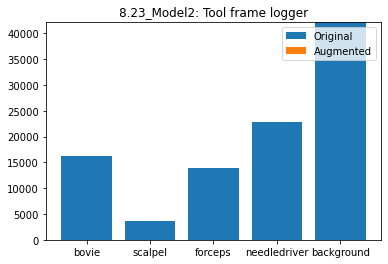

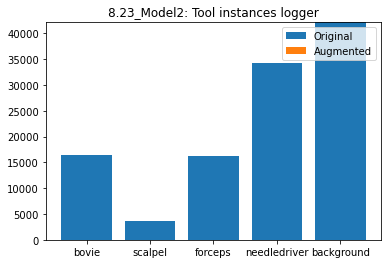

In [27]:
model_name = '8.23_Model2'
generateHistograms(model_name) 


Tool frames log
{'bovie': [6167, 14615], 'scalpel': [4122, 9530], 'forceps': [5595, 13085], 'needledriver': [8851, 20212], 'background': [7120, 16447]}
Tool instances log
{'bovie': [6218, 14805], 'scalpel': [4122, 9530], 'forceps': [6435, 15146], 'needledriver': [13524, 30693], 'background': [7120, 16447]}


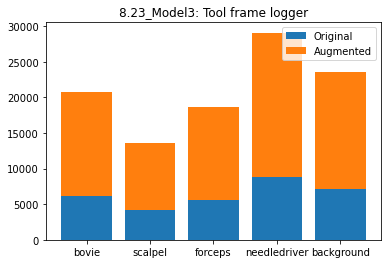

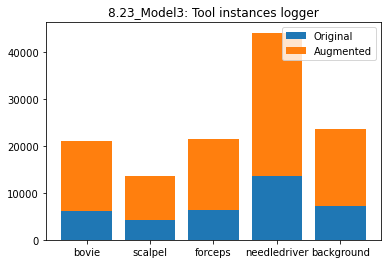

In [28]:
model_name = '8.23_Model3'
generateHistograms(model_name) 


Tool frames log
{'bovie': [2232, 19645], 'scalpel': [1623, 14221], 'forceps': [2066, 17939], 'needledriver': [3032, 27038], 'background': [1944, 17713]}
Tool instances log
{'bovie': [2249, 19921], 'scalpel': [1623, 14221], 'forceps': [2370, 20535], 'needledriver': [4574, 41096], 'background': [1944, 17713]}


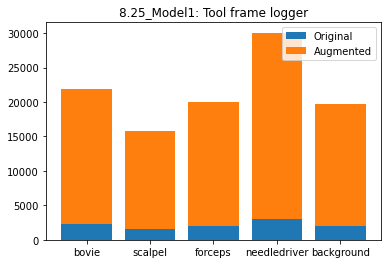

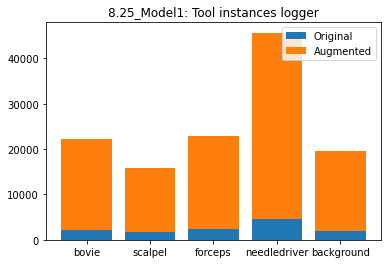

In [29]:
model_name = '8.25_Model1'
generateHistograms(model_name) 
